<a href="https://colab.research.google.com/github/genaiconference/AgenticAI_GenAIHack/blob/main/04_agentic_rag_finance_copilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finance Copilot - LangGraph Architecture

In [ ]:
!git clone https://github.com/genaiconference/AgenticAI_GenAIHack.git

Cloning into 'AgenticAI_GenAIHack'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 131 (delta 65), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (131/131), 6.65 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [ ]:
!pip install -r /content/AgenticAI_GenAIHack/requirements_agenti_ai.txt

In [ ]:
import os
os.chdir("/content/AgenticAI_GenAIHack")

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from typing import Literal
from typing import List, Sequence
import random
import numpy as np
from bs4 import BeautifulSoup
import functools, operator, requests, os, json
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage

from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langgraph.graph import StateGraph, END
from langchain.tools import tool
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
from IPython.display import Markdown

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain_community.utilities import BingSearchAPIWrapper
from langchain.agents import Tool
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_community.callbacks import get_openai_callback

from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.output_parsers import JsonOutputParser
import ast
import re

from prompts import *
from utils import create_MVR, create_qa_agent, create_chat_agent

#### Load environment variables

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="/content/AgenticAI_GenAIHack/.env")

EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_3_DEPLOYMENT_NAME')
EMBEDDING_API_KEY = os.getenv('EMBEDDING_3_API_KEY')
EMBEDDING_API_BASE = os.getenv('EMBEDDING_3_API_BASE')

GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')
GPT4_OMNI_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')

API_KEY = os.getenv('sweden_API_KEY')
API_BASE = os.getenv('sweden_API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

#### Define LLM

In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_deployment=EMBEDDING_DEPLOYMENT_NAME,
    openai_api_key=EMBEDDING_API_KEY,
    azure_endpoint=EMBEDDING_API_BASE,
    openai_api_version=API_VERSION,
)

llm = AzureChatOpenAI(
        azure_endpoint=API_BASE,
        openai_api_version=API_VERSION,
        azure_deployment=GPT4_OMNI_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0)

### Define Tools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Retriever Creation

vector_store_exists = True

_IFRS_ret = create_MVR('IFRS.pickle', embeddings, "IFRS", vectorstore_exists=vector_store_exists, k=7)

_annual_reports_ret = create_MVR('annual_reports.pickle', embeddings, "ANNUAL_REPORTS", vectorstore_exists=vector_store_exists, k=7)

_audit_ret = create_MVR('kpmg.pickle', embeddings, "KPMG", vectorstore_exists=vector_store_exists, k=7)

## Tool Creation

IFRS_tool = create_retriever_tool(retriever=_IFRS_ret,
                                  name = 'IFRS_Retriever',
                                  description="Use this tool to answer questions related to IFRS which is International Financial Reporting Standards.")

ANNUAL_REPORTS_tool = create_retriever_tool(retriever = _annual_reports_ret,
                                        name = "ANNUAL_REPORTS_RETRIEVER",
                                        description = "Use this tool when you need to answer questions related to annual reports, 10K reports or 20F reports of Novartis and it's competitors ('Roche','GSK','Bayer','AstraZeneca','Sanofi', 'Amgen','Abbvie', 'BMS' - Bristol Myers Squibb, 'Gilead', 'Eli Lilly', 'Merck', 'Pfizer', 'Takeda','Johnson&Johnson', 'novo-nordisk'). If no specific year is mentioned in the question, always look for latest available year")

AUDIT_tool = create_retriever_tool(retriever=_audit_ret,
                              name = 'AUDIT_Retriever',
                              description="Use this tool to answer questions related to the Auditor(KPMG, EY, PWC) Insights on IFRS which is International Financial Reporting Standards")

In [ ]:
class FinanceCheck_class(BaseModel):
    """Binary score for finance check on the user question."""
    binary_score: str = Field(description="Given a user question, return 'Yes' if is related to Finance/Accounting/Reporting else 'No'")


def get_finance_check(_llm, META_RESPONSE_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=FinanceCheck_class)
    prompt = PromptTemplate(template=META_RESPONSE_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},
                           )
    prompt_and_model = prompt | llm

    with get_openai_callback() as cb:
        output = prompt_and_model.invoke({"question": question})
        result = parser.invoke(output)
    return result.binary_score


def finance_check_node(state):
    """Use this tool to check whether the user question is about finance or general greeting."""
    observation = get_finance_check(llm, META_RESPONSE_PROMPT_DETAILED, state['question'])

    print("------ENTERING: FINANCE CHECK NODE------")
    print(f"------OBSERVATION: {observation}------")

    return {"finance_check": observation}


def generic_response_node(state):
    """Use this tool to answer user generic questions"""
    print("------ENTERING: GENERIC RESPONSE NODE------")

    answer = llm.invoke(META_ANSWER_PROMPT.format(question=question))

    print(f"------GENERIC RESPONSE: {answer}------")
    return {"generic_response": answer, "final_answer": answer}


class RouteQuery_class(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["FINANCE", "WEB"] = Field(description="Given a user question choose to route it to WEB or FRA.")

def get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=RouteQuery_class)

    prompt = PromptTemplate(template=QUERY_REROUTER_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},
                           )
    prompt_and_model = prompt | llm

    output = prompt_and_model.invoke({"question": question})
    query_rerouter_check = parser.invoke(output)

    return query_rerouter_check.datasource


def query_rerouter_node(state):
    """Use this tool to check whether the user question needs an internet search to answer"""
    print("------ENTERING: QUERY REROUTER NODE------")
    observation = get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT_DETAILED, state['question'])

    print(f"------OBSERVATION: {observation}------")
    return {"query_rerouter_check": observation}



def human_check_node(state):
    user_input = input("The answer is not available from the private data sources! Do you want me to search over the internet to answer?")
    return {"human_response": user_input.lower()}


# Create a tool to processes content from a webpage
@tool("process_content", return_direct=False)
def process_content(url: str, chunk_size: int = 10000) -> str:
    """
    Use this tool to extract content from HTML pages and chunk it recursively.

    Args:
      url (str): The URL of the HTML page to process.
      chunk_size (int, optional): The maximum size of each text chunk. Defaults to 100000.

    Returns:
      str: The chunked text content extracted from the HTML page.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser',from_encoding="iso-8859-1")
    text = soup.get_text()

    def chunk_text(text, chunk_size):
        if len(text) <= chunk_size:
            return text
        else:
            midpoint = len(text) // 2
            left_chunk = chunk_text(text[:midpoint], chunk_size)
            right_chunk = chunk_text(text[midpoint:], chunk_size)
            return left_chunk + "\n" + right_chunk

        chunks = chunk_text(text, chunk_size)
        return chunks


@tool("bing_search", return_direct=False)
def bing_search(query: str) -> str:
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    bing_search = BingSearchAPIWrapper()
    results = bing_search.results(query, 5)
    return results if results else "No results found."


def get_web_search_answer(state):
    tools = [bing_search, process_content]

    generate_prompt = """You are a web searcher trained to retrieve the current events from the internet. Search the internet for information.
                            Generate the best answer possible for the user's request with mandatory mention of the sources and the hyperlinks for the sources wherever it is possible.
                            Think step by step. Breakdown the question if it has multiple asks and finally merge your results.
                            Always crave for the best version of answer.
                            - **Always** before giving the final answer, try another method.Then reflect on the answers of the two methods you did and ask yourself if it answers correctly the original question. If you are not sure, try another method.
                            - If the methods tried do not give the same result, reflect and try again until you have two methods that have the same result.
                            - If you are sure of the correct answer, create a beautiful and thorough response.
                            ** DO NOT MAKE UP AN ANSWER OR USE YOUR PRIOR KNOWLEDGE, ONLY USE THE RESULTS OF THE CALCULATIONS YOU HAVE DONE **
                            PLEASE NOTE THAT IF NO SPECIFIC YEAR MENTIONED IN THE QUESTION, ALWAYS LOOK FOR THE LATEST YEAR.
                            """

    generate_agent = create_qa_agent(llm, tools, generate_prompt, verbose=False)
    answer = generate_agent.invoke({"input": state['question']})
    return answer['output']


def web_search_node(state):
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    print("------ENTERING: WEB SEARCH NODE------")
    ## Write code here to get answer
    response = get_web_search_answer(state)
    print(f"------WEB SEARCH ANSWER: {response}------")
    return {"web_response": response, "final_answer": response}


def get_source_detector_check(llm, SOURCE_DETECTOR_PROMPT, selected_source_list, question):
    parser = JsonOutputParser()
    prompt = PromptTemplate(template=SOURCE_DETECTOR_PROMPT,
                            input_variables=["question"],
                            partial_variables={"role_based_sources": selected_source_list , "format_instructions": parser.get_format_instructions()},
                           )
    chain = prompt | llm | parser
    source_detector_check = chain.invoke({"question": question})

    return source_detector_check['Output']


def source_detector_node(state):
    """Use this tool to detect the sources needed for the question to answer"""
    print("------ENTERING: SOURCE DETECTOR NODE------")

    selected_source_list = ["ifrs_answer_node", "annual_reports_answer_node", "auditor_guidance_answer_node"]
    sources_detected = get_source_detector_check(llm, SOURCE_DETECTOR_PROMPT_DETAILED, selected_source_list, state['question'])
    print(f"------SOURCES DETECTED: {list(set(sources_detected))}------")
    return {"source_detector_check": list(set(sources_detected))}


def ifrs_answer_node(state):
    """Use this tool to answer ifrs related questions"""
    print("------ENTERING: IFRS ANSWER NODE------")

    tools = [IFRS_tool]
    generate_agent = create_qa_agent(llm, tools, IFRS_di_prompt, verbose=False)
    answer = generate_agent.invoke({"input":state['question']})
    final_answer = f"""**IFRS ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="red">{final_answer}</font>"""))
    return {"ifrs_response": answer['output'], 'final_answer':final_answer}


def auditor_guidance_answer_node(state):
    """Use this tool to answer audit related questions"""
    print("------ENTERING: AUDITOR GUIDANCE ANSWER NODE------")
    tools = [AUDIT_tool]
    generate_agent = create_qa_agent(llm, tools, KPMG_EY_PwC_prompt, verbose=False)
    answer = generate_agent.invoke({"input":state['question']})
    final_answer = f"""**AUDITOR GUIDANCE ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="red">{final_answer}</font>"""))
    return {"audit_response": answer['output'], 'final_answer':final_answer}


def annual_reports_answer_node(state):
    """Use this tool to answer annual reports related questions"""
    print("------ENTERING: ANNUAL REPORTS ANSWER NODE------")
    all_competitors = ['Roche','GSK','Bayer','AstraZeneca','Sanofi', 'Amgen', 'Biogen', 'Abbvie', 'BMS/Bristol Myers Squibb', 'Gilead', 'Eli Lilly', 'Merck', 'Pfizer', 'Takeda','Johnson&Johnson', 'novo-nordisk']

    competitors = ['Roche', 'Sanofi', 'Bayer', 'GSK', 'AstraZeneca']
    web_tool = bing_search

    tools = [ANNUAL_REPORTS_tool, web_tool]
    generate_agent = create_qa_agent(llm, tools, AR_prompt, verbose=False)
    answer = generate_agent.invoke({"input":state['question'], 'all_competitors':all_competitors, 'top5_competitors':competitors })
    final_answer = f"""**ANNUAL REPORTS ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="red">{final_answer}</font>"""))
    return {"annual_reports_response": answer['output'], 'final_answer':final_answer}


def overall_status_check_node(state):
    """Use this tool to check the overall status and update the config settings"""
    print("------ENTERING: OVERALL STATUS CHECK NODE------")
    final_answer = state['final_answer']
    observation = "Completed"
    print("-------------------------------- {} --------------------------------".format(red("Final Answer", ['bold'])))
    display(Markdown(f"""**FINAL ANSWER:**\n\n <font color="red">{final_answer}</font>"""))

    return {"overall_status_check": observation, 'final_answer':final_answer}

In [ ]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict
from typing import Annotated, List
from langchain_core.messages import AnyMessage
import operator


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        finance_check: whether user question needs finance answer or generic answer
        generic_response: generic answer
        query_rerouter_check: whether user question needs web search or fra sources to answer
        web_search: web answer
        source_detector: List of fra sources applicable for answering the user question
        ifrs_answer: ifrs answer
        annual_reports_answer: annual reports answer
        fm_answer: foundational model answer
        unified_answer: consistency check and unified answer
    """

    operation_id: int
    question: str
    final_answer: Annotated[str, operator.add]

    finance_check: str
    query_rerouter_check: str
    source_detector_check: List[str]
    overall_status_check: str

    generic_response: str
    human_response: str
    web_response: str
    ifrs_response: str
    annual_reports_response: str
    audit_response: str
    intermediate_steps: Annotated[list[AnyMessage], operator.add]



## Main Graph

builder = StateGraph(GraphState)
builder.add_node("finance_check_node", finance_check_node)
builder.add_node("generic_response_node", generic_response_node)
builder.add_node("query_rerouter_node", query_rerouter_node)
builder.add_node("human_check_node", human_check_node)
builder.add_node("web_search_node", web_search_node)
builder.add_node("source_detector_node", source_detector_node)
builder.add_node("ifrs_answer_node", ifrs_answer_node)
builder.add_node("annual_reports_answer_node", annual_reports_answer_node)
builder.add_node("auditor_guidance_answer_node", auditor_guidance_answer_node)
builder.add_node("overall_status_check_node", overall_status_check_node)

builder.set_entry_point("finance_check_node")

def finance_check_edge(state):
    if state["finance_check"] == "Yes":
        print("------DECISION: INVOKE QUERY REROUTER NODE------")
        return "query_rerouter_node"
    else:
        print("------DECISION: INVOKE GENERIC RESPONSE NODE------")
        return "generic_response_node"


finance_check_possible_nodes = ["query_rerouter_node", "generic_response_node"]
builder.add_conditional_edges("finance_check_node", finance_check_edge, finance_check_possible_nodes)
builder.add_edge("generic_response_node", "overall_status_check_node")


def query_rerouter_edge(state):
    if state["query_rerouter_check"] == "FINANCE":
        print("------DECISION: INVOKE SOURCE DETECTOR NODE------")
        return "source_detector_node"
    else:
        print("------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------")
        return "human_check_node"


query_rerouter_possible_nodes = ["human_check_node", "source_detector_node"]
builder.add_conditional_edges("query_rerouter_node", query_rerouter_edge, query_rerouter_possible_nodes)


def human_check_edge(state):
    if state['human_response'] == "yes":
        print("------DECISION: INVOKE WEB SEARCH NODE------")
        return "web_search_node"
    else:
        print("------Your question cannot be answered due to lack of information from private data sources, please ask a different question!------")
        return "overall_status_check_node"


builder.add_conditional_edges("human_check_node", human_check_edge, ["web_search_node", "overall_status_check_node"])

builder.add_edge("web_search_node", "overall_status_check_node")


def source_detector_edge(state) -> list:
    return state["source_detector_check"]


individual_answer_nodes = ["annual_reports_answer_node", "ifrs_answer_node", "auditor_guidance_answer_node"]
builder.add_conditional_edges("source_detector_node", source_detector_edge, individual_answer_nodes)

for node in individual_answer_nodes:
    builder.add_edge(node, "overall_status_check_node")

builder.set_finish_point("overall_status_check_node")

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile()

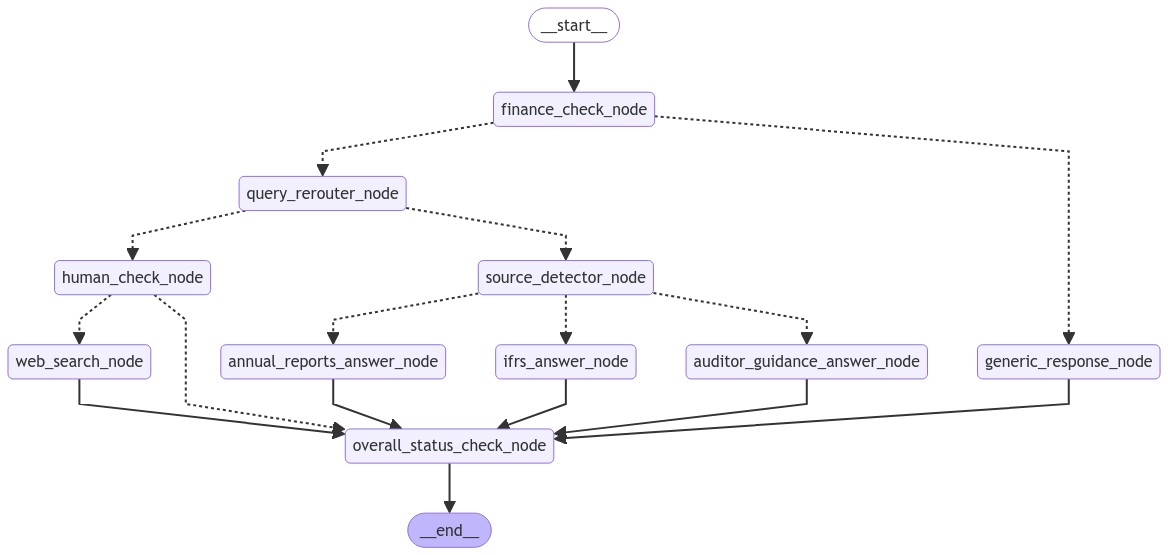

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import time
from simple_colors import *

def run_answer(question, t):
    inputs = {"question": question, "operation_id": 123456}
    thread = {"configurable": {"thread_id": str(t)}}
    start_time = time.time()
    for output in graph.stream(inputs, thread, stream_mode='values'):
#         print(blue(output, ['bold']))
        pass
    ex_time = time.time() - start_time
    print("--------------------------------------------------------")
    print(red(f"Total Time Taken - [{round(ex_time, 2)}]", ['bold']))
    print("--------------------------------------------------------")
    return

In [ ]:
question = "What is the income of bayer in 2024 Q1?"
run_answer(question, 89)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: WEB------
------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------
The answer is not available from the private data sources! Do you want me to search over the internet to answer?
------Your question cannot be answered due to lack of information from private data sources, please ask a different question!------
------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="red"></font>

--------------------------------------------------------
Total Time Taken - [2.97]
--------------------------------------------------------


In [ ]:
question = "What is the guidance for identifying a lease as per IFRS?"
run_answer(question, 89)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
------SOURCES DETECTED: ['ifrs_answer_node']------
------ENTERING: IFRS ANSWER NODE------


<font color="red">**IFRS ANSWER:** As per IFRS 16, the guidance for identifying a lease is as follows:

- **Assessment at Inception**: At the inception of a contract, an entity must assess whether the contract is, or contains, a lease. A contract is considered a lease if it conveys the right to control the use of an identified asset for a period of time in exchange for consideration (IFRS 16, paragraph 9).

- **Right to Control**: To determine if a contract conveys the right to control the use of an identified asset, the entity must assess whether, throughout the period of use, the customer has both:
  - The right to obtain substantially all of the economic benefits from the use of the identified asset (paragraphs B21-B23).
  - The right to direct the use of the identified asset (paragraphs B24-B30) (IFRS 16, paragraph B9).

- **Identified Asset**: An asset is typically identified by being explicitly specified in a contract. However, it can also be identified implicitly at the time the asset is made available for use by the customer (IFRS 16, paragraph B13).

- **Reassessment**: An entity must reassess whether a contract is, or contains, a lease only if the terms and conditions of the contract are changed (IFRS 16, paragraph 11).

- **Separating Components**: For a contract that is, or contains, a lease, an entity must account for each lease component within the contract separately from non-lease components, unless the practical expedient in paragraph 15 is applied (IFRS 16, paragraph 12).

- **Flowchart for Assessment**: A flowchart is provided in IFRS 16 to assist entities in making the assessment of whether a contract is, or contains, a lease (IFRS 16, paragraph B31).

These steps ensure that entities correctly identify and account for leases in accordance with IFRS 16. 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="red">**IFRS ANSWER:** As per IFRS 16, the guidance for identifying a lease is as follows:

- **Assessment at Inception**: At the inception of a contract, an entity must assess whether the contract is, or contains, a lease. A contract is considered a lease if it conveys the right to control the use of an identified asset for a period of time in exchange for consideration (IFRS 16, paragraph 9).

- **Right to Control**: To determine if a contract conveys the right to control the use of an identified asset, the entity must assess whether, throughout the period of use, the customer has both:
  - The right to obtain substantially all of the economic benefits from the use of the identified asset (paragraphs B21-B23).
  - The right to direct the use of the identified asset (paragraphs B24-B30) (IFRS 16, paragraph B9).

- **Identified Asset**: An asset is typically identified by being explicitly specified in a contract. However, it can also be identified implicitly at the time the asset is made available for use by the customer (IFRS 16, paragraph B13).

- **Reassessment**: An entity must reassess whether a contract is, or contains, a lease only if the terms and conditions of the contract are changed (IFRS 16, paragraph 11).

- **Separating Components**: For a contract that is, or contains, a lease, an entity must account for each lease component within the contract separately from non-lease components, unless the practical expedient in paragraph 15 is applied (IFRS 16, paragraph 12).

- **Flowchart for Assessment**: A flowchart is provided in IFRS 16 to assist entities in making the assessment of whether a contract is, or contains, a lease (IFRS 16, paragraph B31).

These steps ensure that entities correctly identify and account for leases in accordance with IFRS 16. 

</font>

--------------------------------------------------------
Total Time Taken - [10.95]
--------------------------------------------------------


In [ ]:
question = "How do I account for Gains on sales of fixed assets?"
run_answer(question, 89)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
------SOURCES DETECTED: ['ifrs_answer_node', 'auditor_guidance_answer_node', 'annual_reports_answer_node']------
------ENTERING: IFRS ANSWER NODE------------ENTERING: ANNUAL REPORTS ANSWER NODE------

------ENTERING: AUDITOR GUIDANCE ANSWER NODE------


<font color="red">**ANNUAL REPORTS ANSWER:** NO GUIDANCE 

</font>

<font color="red">**IFRS ANSWER:** As per IAS 16, gains on the sale of fixed assets (property, plant, and equipment) should be accounted for as follows:

- **Derecognition**: The carrying amount of the asset should be derecognized at the date of disposal (IAS 16, paragraph 67-72).
- **Recognition of Gain**: Any gain or loss arising from the derecognition of an item of property, plant, and equipment should be included in profit or loss when the item is derecognized (IAS 16, paragraph 68).
- **Measurement**: The gain or loss on disposal is determined as the difference between the net disposal proceeds and the carrying amount of the asset (IAS 16, paragraph 71).

Therefore, the gain on the sale of fixed assets should be recognized in the profit or loss statement at the date of derecognition, calculated as the difference between the net disposal proceeds and the carrying amount of the asset. 

</font>

<font color="red">**AUDITOR GUIDANCE ANSWER:** As per IAS 16:

- When an item of property, plant, and equipment is disposed of or permanently withdrawn from use, a gain or loss is recognized for the difference between any net proceeds received and the carrying amount of the asset (IAS 16.71-72) [KPMG, page 29].
- The gain or loss on derecognition is generally included in profit or loss but is not classified as revenue (IAS 16.67-68, 71) [KPMG, page 29].
- In determining the net proceeds received, all directly attributable incremental costs of disposal should generally be deducted (KPMG, page 29).
- If an item of property, plant, and equipment is disposed of as part of a sale-and-leaseback transaction, then an entity applies the requirements in IFRS 16 (KPMG, page 29).

Therefore, the gain on the sale of fixed assets should be calculated as the difference between the net proceeds from the sale and the carrying amount of the asset, and this gain should be recognized in profit or loss. 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="red">**IFRS ANSWER:** As per IAS 16, gains on the sale of fixed assets (property, plant, and equipment) should be accounted for as follows:

- **Derecognition**: The carrying amount of the asset should be derecognized at the date of disposal (IAS 16, paragraph 67-72).
- **Recognition of Gain**: Any gain or loss arising from the derecognition of an item of property, plant, and equipment should be included in profit or loss when the item is derecognized (IAS 16, paragraph 68).
- **Measurement**: The gain or loss on disposal is determined as the difference between the net disposal proceeds and the carrying amount of the asset (IAS 16, paragraph 71).

Therefore, the gain on the sale of fixed assets should be recognized in the profit or loss statement at the date of derecognition, calculated as the difference between the net disposal proceeds and the carrying amount of the asset. 

**ANNUAL REPORTS ANSWER:** NO GUIDANCE 

**AUDITOR GUIDANCE ANSWER:** As per IAS 16:

- When an item of property, plant, and equipment is disposed of or permanently withdrawn from use, a gain or loss is recognized for the difference between any net proceeds received and the carrying amount of the asset (IAS 16.71-72) [KPMG, page 29].
- The gain or loss on derecognition is generally included in profit or loss but is not classified as revenue (IAS 16.67-68, 71) [KPMG, page 29].
- In determining the net proceeds received, all directly attributable incremental costs of disposal should generally be deducted (KPMG, page 29).
- If an item of property, plant, and equipment is disposed of as part of a sale-and-leaseback transaction, then an entity applies the requirements in IFRS 16 (KPMG, page 29).

Therefore, the gain on the sale of fixed assets should be calculated as the difference between the net proceeds from the sale and the carrying amount of the asset, and this gain should be recognized in profit or loss. 

</font>

--------------------------------------------------------
Total Time Taken - [7.97]
--------------------------------------------------------


In [ ]:
question = "What is the revenue trend of GSK?"
run_answer(question, 19)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
------SOURCES DETECTED: ['annual_reports_answer_node']------
------ENTERING: ANNUAL REPORTS ANSWER NODE------


<font color="red">**ANNUAL REPORTS ANSWER:** ### Revenue Trend of GSK (2020-2023)

- **2020**: GSK reported total sales of £34.1 billion.
- **2021**: GSK's total sales were £34.1 billion, showing no significant change from the previous year.
- **2022**: GSK's total sales were £29.3 billion, indicating a decrease from the previous year.
- **2023**: GSK's total sales increased to £30.3 billion, showing a growth of 3% in AER and 5% in CER.

### Summary
- **2020**: £34.1 billion
- **2021**: £34.1 billion
- **2022**: £29.3 billion
- **2023**: £30.3 billion

The revenue trend shows a slight decline in 2022 followed by a recovery and growth in 2023. 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="red">**ANNUAL REPORTS ANSWER:** ### Revenue Trend of GSK (2020-2023)

- **2020**: GSK reported total sales of £34.1 billion.
- **2021**: GSK's total sales were £34.1 billion, showing no significant change from the previous year.
- **2022**: GSK's total sales were £29.3 billion, indicating a decrease from the previous year.
- **2023**: GSK's total sales increased to £30.3 billion, showing a growth of 3% in AER and 5% in CER.

### Summary
- **2020**: £34.1 billion
- **2021**: £34.1 billion
- **2022**: £29.3 billion
- **2023**: £30.3 billion

The revenue trend shows a slight decline in 2022 followed by a recovery and growth in 2023. 

</font>

--------------------------------------------------------
Total Time Taken - [5.62]
--------------------------------------------------------


In [ ]:
question = "Where do i find company master data change request form?"
run_answer(question, 19)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
------SOURCES DETECTED: ['ifrs_answer_node', 'auditor_guidance_answer_node', 'annual_reports_answer_node']------
------ENTERING: IFRS ANSWER NODE------------ENTERING: ANNUAL REPORTS ANSWER NODE------
------ENTERING: AUDITOR GUIDANCE ANSWER NODE------



<font color="red">**IFRS ANSWER:** NO GUIDANCE 

</font>

<font color="red">**AUDITOR GUIDANCE ANSWER:** No sufficient information 

</font>

<font color="red">**ANNUAL REPORTS ANSWER:** You can find the company master data change request form on the Novartis Supplier Portal. Here is the link to access it:

[Novartis Supplier Portal](https://www.novartis.com/supplier-portal) 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="red">**IFRS ANSWER:** NO GUIDANCE 

**ANNUAL REPORTS ANSWER:** You can find the company master data change request form on the Novartis Supplier Portal. Here is the link to access it:

[Novartis Supplier Portal](https://www.novartis.com/supplier-portal) 

**AUDITOR GUIDANCE ANSWER:** No sufficient information 

</font>

--------------------------------------------------------
Total Time Taken - [6.27]
--------------------------------------------------------
